In [1]:
import os
import time
import copy
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms as transforms

from PIL import Image
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, Dataset
from torch.autograd import Variable

In [2]:
# Fixed seed for reproducibility of results
torch.manual_seed(42)

In [3]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Source: Post by "kuzand" @https://discuss.pytorch.org/t/computing-the-mean-and-std-of-dataset/34949/2
def get_mean_std(loader):
    mean = 0.
    std = 0.
    for images, _ in loader:
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    return mean, std

In [5]:
imsize = 125
data_dir = 'data'

In [8]:
# Random split into training and testing dataset
full_dataset = ImageFolder(data_dir)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_subset, test_subset = random_split(full_dataset, [train_size, test_size])

In [9]:
# Source: https://discuss.pytorch.org/t/torch-utils-data-dataset-random-split/32209/4
class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [10]:
# Compute mean and std of training data
train_copy = copy.copy(train_subset)  # Copy training dataset to prevent in-place modifications
train_dataset = DatasetFromSubset(train_copy, transform=transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()
]))
data_loader = DataLoader(train_dataset, batch_size=4, shuffle=False, num_workers=8)
train_mean, train_std = get_mean_std(data_loader)

In [11]:
train_mean, train_std

(tensor([0.5728, 0.5529, 0.4698]), tensor([0.2405, 0.2433, 0.2528]))

In [12]:
class_names = full_dataset.classes
class_names

['avocado_ripe', 'avocado_unripe', 'other']

In [17]:
# Source: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [30]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(int(0.8 * imsize)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=train_mean, std=train_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(imsize),
        transforms.CenterCrop(int(0.8 * imsize)),
        transforms.ToTensor(),
        transforms.Normalize(mean=train_mean, std=train_std)
    ]),
}

train_dataset = DatasetFromSubset(train_subset, transform=data_transforms['train'])
val_dataset = DatasetFromSubset(test_subset, transform=data_transforms['val'])

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=8),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=8)
}

dataset_sizes = {
    'train': len(train_subset),
    'val': len(test_subset)
}

In [31]:
# Show a couple images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(train_mean)
    std = np.array(train_std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(1)  # pause a bit so that plots are updated

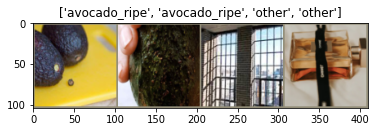

In [32]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [33]:
# Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [34]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [35]:
model_ft = models.resnet18(pretrained=True)
# for param in model_ft.parameters():
#     param.requires_grad = False

num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [36]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 1.0446 Acc: 0.4768
val Loss: 0.5801 Acc: 0.7368

Epoch 1/49
----------
train Loss: 0.8933 Acc: 0.6358
val Loss: 0.6906 Acc: 0.6842

Epoch 2/49
----------
train Loss: 0.8287 Acc: 0.6821
val Loss: 0.3926 Acc: 0.8421

Epoch 3/49
----------
train Loss: 0.8310 Acc: 0.7152
val Loss: 0.5397 Acc: 0.7895

Epoch 4/49
----------
train Loss: 0.8662 Acc: 0.6954
val Loss: 0.4232 Acc: 0.8158

Epoch 5/49
----------
train Loss: 0.6886 Acc: 0.7351
val Loss: 0.4725 Acc: 0.8421

Epoch 6/49
----------
train Loss: 0.7634 Acc: 0.7550
val Loss: 0.4883 Acc: 0.8158

Epoch 7/49
----------
train Loss: 0.4917 Acc: 0.8278
val Loss: 0.4145 Acc: 0.8421

Epoch 8/49
----------
train Loss: 0.6753 Acc: 0.7351
val Loss: 0.3783 Acc: 0.8421

Epoch 9/49
----------
train Loss: 0.4852 Acc: 0.8013
val Loss: 0.3915 Acc: 0.8684

Epoch 10/49
----------
train Loss: 0.6490 Acc: 0.7550
val Loss: 0.3771 Acc: 0.8947

Epoch 11/49
----------
train Loss: 0.4525 Acc: 0.7947
val Loss: 0.3868 Acc: 0.8684

Ep

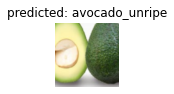

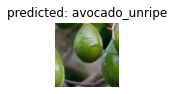

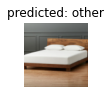

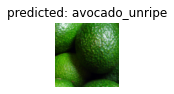

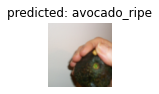

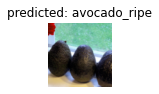

In [37]:
visualize_model(model_ft)

In [38]:
loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor(), 
    transforms.Normalize(mean=train_mean, std=train_std)
])

def predict(model, img_path):
    img = Image.open(img_path)
    plt.imshow(img)
    img = loader(img).float()
    img = img.unsqueeze(0)
    p, idx = F.softmax(model.forward(img)).max(1)
    return p.item(), class_names[idx]

In [40]:
torch.save(model_ft.state_dict(), 'model')

In [51]:
# predict(model_ft, 'data/avocado_7.jpg')